In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../../src/')

%load_ext autoreload
%autoreload 2

#%pdb

<IPython.core.display.Javascript object>

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import copy
import pickle
import model_archs

from utils_plot import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot, plot_data, show_sws_weights_log
from utils_model import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty, layer_accuracy
from utils_misc import trueAfterN, logsumexp, root_dir, model_load_dir, get_ab, get_sparsity
from utils_sws import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune, sws_prune_l2, sws_prune_copy
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size
from extract_targets import get_targets
from retrain_layer import init_retrain_layer
#from retrain_model import retrain_model

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [14]:
from utils_plot import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot, plot_data
from utils_model import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty
from utils_misc import trueAfterN, logsumexp, root_dir, model_load_dir, get_ab, get_sparsity
from utils_sws import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune, sws_prune_l2, sws_prune_copy, compressed_model
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size

def retrain_model(mean, var, zmean, zvar, tau, temp, mixtures, model_name, mode, loss_type = 'MSESNT', scaling = False, model_save_dir = "",  fn="", dset="mnist"):
    ab = get_ab(mean, var)
    zab = get_ab(zmean, zvar)
    
    test_data_full = Variable(test_data(fetch='data', dset=dset)).cuda()
    test_labels_full = Variable(test_data(fetch='labels', dset=dset)).cuda()

    model_file = '{}_{}_{}_{}'.format(dset, "LeNet_300_100", 100, "full")
    model = torch.load(model_load_dir + model_file + '.m').cuda()

    train_input = train_data(fetch = "data", dset=dset)[0:1000].cuda()
    if (mode == "sws"):
        output = train_data(fetch = "labels", dset=dset)[0:1000].cuda()
        retraining_epochs = 250
    if (mode == "kd"):
        output = model(Variable(train_input))
        output = (nn.Softmax(dim=1)(output/temp)).data
        retraining_epochs = 250
    if (mode == "synth"):
        #data_aug 1
        if (True):
            mean=train_input.mean(dim=0).cpu().numpy()
            std=train_input.std(dim=0).cpu().numpy()
            new_data = np.concatenate([[np.random.normal(mean, std) for x in range(10000)]], axis=1)
            train_data_exp = torch.Tensor(new_data).clamp(0,1).cuda()
            train_input_exp = torch.cat([train_input + (torch.FloatTensor(1000, 28, 28).normal_(0, 0.2)).cuda() for x in range(10)]).clamp(0, 1)
        if (False):
            train_input_exp = torch.load("synth_data_2.m")
        output = model(Variable(train_input_exp))
        output = (nn.Softmax(dim=1)(output/temp)).data
        train_input = train_input_exp
        retraining_epochs = 250

    dataset = torch.utils.data.TensorDataset(train_input, output)
    loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

    s = "s" if scaling else "f" 
    exp_name = "{}_m{}_zm{}_r{}_t{}_m{}_kdT{}_{}_{}".format(model.name, mean, zmean, retraining_epochs, tau, int(mixtures), int(temp), s, mode) + fn
    gmp = GaussianMixturePrior(mixtures, [x for x in model.parameters()], 0.99, zero_ab = zab, ab = ab, scaling = scaling)
    gmp.print_batch = False

    mlr = 0.5e-4 if scaling else 0.5e-4

    optimizable_params = [
        {'params': model.parameters(), 'lr': 5e-4},
        {'params': [gmp.means], 'lr': mlr},
        {'params': [gmp.gammas, gmp.rhos], 'lr': 3e-3}]
    if (scaling):
        optimizable_params = optimizable_params + [{'params': gmp.scale, 'lr': 1e-6}]

    opt = torch.optim.Adam(optimizable_params)#log precisions and mixing proportions

    res_stats = plot_data(init_model = model, gmp = gmp, mode = 'retrain', data_size = "full", loss_type='CE', mv = (mean, var), zmv = (zmean, zvar), tau = tau, temp = temp, mixtures = mixtures, dset=dset)
    s_hist = []
    a_hist = []
    for epoch in range(retraining_epochs):
        ### [ACT DISABLE LR]
        if(scaling and epoch == 0):
            opt.param_groups[3]['lr'] = 0
            print ("Scaling Disabled - Epoch {}".format(epoch))
        model, loss = retrain_sws_epoch(model, gmp, opt, loader, tau, temp, loss_type)
        res_stats.data_epoch(epoch + 1, model, gmp)


        if (trueAfterN(epoch, 10)):
            #test_acc = test_accuracy(test_data_full, test_labels_full, model)
            nm = sws_prune_copy(model, gmp)
            s = get_sparsity(nm)
            a = test_accuracy(test_data_full, test_labels_full, nm)[0]

            print('Epoch: {}. Test Accuracy: {:.2f}, Prune Accuracy: {:.2f}, Sparsity: {:.2f}'.format(epoch+1, res_stats.test_accuracy[-1], a, s))
            #show_sws_weights(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()), epoch = epoch)###
        nm = sws_prune_copy(model, gmp)
        s = get_sparsity(nm)
        a = test_accuracy(test_data_full, test_labels_full, nm)[0]
        s_hist.append(s)
        a_hist.append(a)

    res = res_stats.gen_dict()

    model_prune = sws_prune_copy(model, gmp)

    res_stats.data_prune(model_prune)
    res = res_stats.gen_dict()
    res['test_prune_acc'] = a_hist
    res['test_prune_sp'] = s_hist
    cm = compressed_model(model_prune.state_dict(), [gmp])
    res['cm'] = cm.get_cr_list()

    print('Retrain Test: {:.2f}, Prune Test: {:.2f}, Prune Sparsity: {:.2f}'.format(res['test_acc'][-1], res['prune_acc']['test'],res['sparsity']))

    if(model_save_dir!=""):
        torch.save(model, model_save_dir + '/mnist_retrain_model_{}.m'.format(exp_name))
        with open(model_save_dir + '/mnist_retrain_gmp_{}.p'.format(exp_name),'wb') as f:
            pickle.dump(gmp, f)
        with open(model_save_dir + '/mnist_retrain_res_{}.p'.format(exp_name),'wb') as f:
            pickle.dump(res, f)

    return model, gmp, res

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 1.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.18, Prune Accuracy: 97.80, Sparsity: 54.30
Epoch: 20. Test Accuracy: 97.72, Prune Accuracy: 96.37, Sparsity: 72.96
Epoch: 30. Test Accuracy: 96.93, Prune Accuracy: 92.99, Sparsity: 82.70
Epoch: 40. Test Accuracy: 96.01, Prune Accuracy: 77.89, Sparsity: 87.36
Epoch: 50. Test Accuracy: 94.94, Prune Accuracy: 67.40, Sparsity: 89.23
Epoch: 60. Test Accuracy: 94.16, Prune Accuracy: 65.56, Sparsity: 91.05
Epoch: 70. Test Accuracy: 94.18, Prune Accuracy: 61.33, Sparsity: 92.44
Epoch: 80. Test Accuracy: 93.40, Prune Accuracy: 55.10, Sparsity: 94.21
Epoch: 90. Test Accuracy: 93.49, Prune Accuracy: 46.23, Sparsity: 95.98
Epoch: 100. Test Accuracy: 92.83, Prune Accuracy: 42.15, Sparsity: 97.50
Epoch: 110. Test Accuracy: 92.18, Prune Accuracy: 25.08, Sparsity: 98.43
Epoch: 120. Test Accuracy: 92.04, Prune Accuracy: 28.78, Sparsity: 98.92
Epoch: 130. Test Accuracy: 91.84, Prune Accuracy

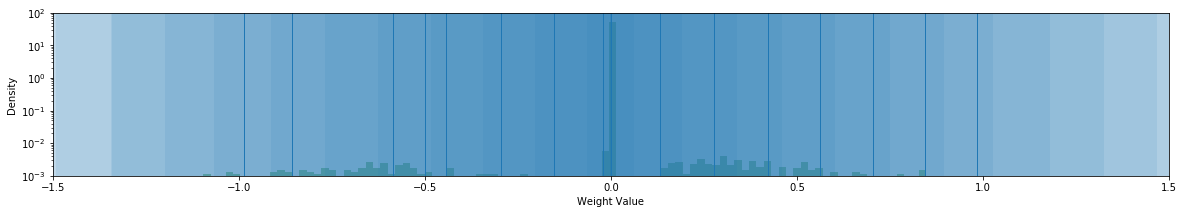

In [130]:
model, gmp, res = retrain_model(1, 0.1, 1000, 1000, 5e-6, int(0), 16, "LeNet_300_100", "sws", 'CESNT', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 250.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.25, Prune Accuracy: 98.08, Sparsity: 49.13
Epoch: 20. Test Accuracy: 97.69, Prune Accuracy: 97.37, Sparsity: 61.89
Epoch: 30. Test Accuracy: 96.88, Prune Accuracy: 96.51, Sparsity: 68.68
Epoch: 40. Test Accuracy: 96.02, Prune Accuracy: 95.74, Sparsity: 72.40
Epoch: 50. Test Accuracy: 95.51, Prune Accuracy: 94.44, Sparsity: 75.37
Epoch: 60. Test Accuracy: 94.72, Prune Accuracy: 90.13, Sparsity: 77.90
Epoch: 70. Test Accuracy: 94.27, Prune Accuracy: 74.36, Sparsity: 88.27
Epoch: 80. Test Accuracy: 94.00, Prune Accuracy: 66.03, Sparsity: 93.88
Epoch: 90. Test Accuracy: 93.76, Prune Accuracy: 60.43, Sparsity: 95.93
Epoch: 100. Test Accuracy: 93.55, Prune Accuracy: 54.46, Sparsity: 97.35
Epoch: 110. Test Accuracy: 93.18, Prune Accuracy: 51.42, Sparsity: 98.38
Epoch: 120. Test Accuracy: 92.88, Prune Accuracy: 50.55, Sparsity: 99.07
Epoch: 130. Test Accuracy: 92.55, Prune Accur

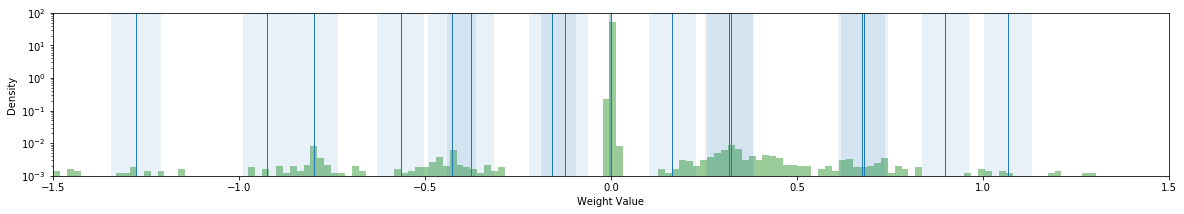

In [131]:
model, gmp, res = retrain_model(250, 10, 2500, 1250, 5e-6, 5, 16, "LeNet_300_100", "kd", 'MSEST', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 250.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.70, Prune Accuracy: 96.78, Sparsity: 58.55
Epoch: 20. Test Accuracy: 94.46, Prune Accuracy: 69.77, Sparsity: 96.34
Epoch: 30. Test Accuracy: 90.93, Prune Accuracy: 77.64, Sparsity: 90.71
Epoch: 40. Test Accuracy: 89.43, Prune Accuracy: 84.97, Sparsity: 99.32
Epoch: 50. Test Accuracy: 89.16, Prune Accuracy: 86.62, Sparsity: 99.47
Epoch: 60. Test Accuracy: 89.90, Prune Accuracy: 87.67, Sparsity: 99.47
Epoch: 70. Test Accuracy: 89.55, Prune Accuracy: 87.45, Sparsity: 99.47
Epoch: 80. Test Accuracy: 89.79, Prune Accuracy: 87.59, Sparsity: 99.42
Epoch: 90. Test Accuracy: 89.64, Prune Accuracy: 88.52, Sparsity: 97.91
Epoch: 100. Test Accuracy: 90.04, Prune Accuracy: 88.64, Sparsity: 99.26
Epoch: 110. Test Accuracy: 89.89, Prune Accuracy: 87.91, Sparsity: 99.41
Epoch: 120. Test Accuracy: 89.72, Prune Accuracy: 88.58, Sparsity: 99.41
Epoch: 130. Test Accuracy: 89.83, Prune Accur

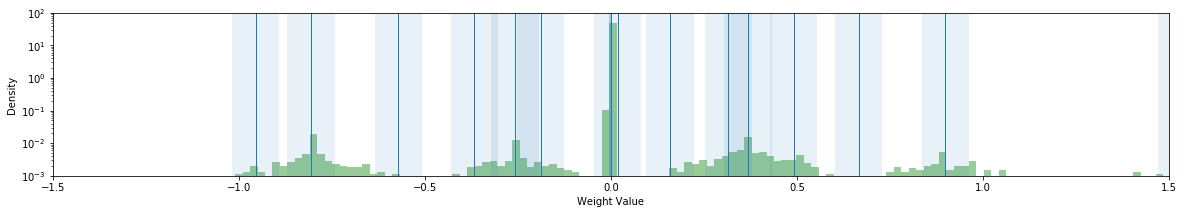

In [132]:
model, gmp, res = retrain_model(250, 10, 2500, 1250, 5e-6, 5, 16, "LeNet_300_100", "synth", 'MSEST', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 250.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.33, Prune Accuracy: 98.16, Sparsity: 36.82
Epoch: 20. Test Accuracy: 97.94, Prune Accuracy: 97.24, Sparsity: 53.64
Epoch: 30. Test Accuracy: 96.67, Prune Accuracy: 54.89, Sparsity: 93.92
Epoch: 40. Test Accuracy: 92.51, Prune Accuracy: 64.68, Sparsity: 98.84
Epoch: 50. Test Accuracy: 93.17, Prune Accuracy: 76.84, Sparsity: 98.84
Epoch: 60. Test Accuracy: 93.34, Prune Accuracy: 81.55, Sparsity: 98.85
Epoch: 70. Test Accuracy: 92.98, Prune Accuracy: 81.40, Sparsity: 98.85
Epoch: 80. Test Accuracy: 93.67, Prune Accuracy: 82.41, Sparsity: 98.85
Epoch: 90. Test Accuracy: 93.99, Prune Accuracy: 81.48, Sparsity: 98.86
Epoch: 100. Test Accuracy: 93.62, Prune Accuracy: 82.63, Sparsity: 98.86
Epoch: 110. Test Accuracy: 93.50, Prune Accuracy: 82.89, Sparsity: 98.87
Epoch: 120. Test Accuracy: 93.84, Prune Accuracy: 84.42, Sparsity: 98.87
Epoch: 130. Test Accuracy: 93.52, Prune Accur

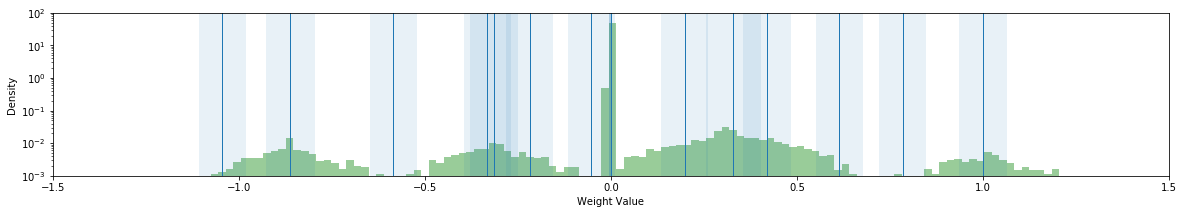

In [128]:
model, gmp, res = retrain_model(250, 10, 2500, 1250, 5e-6, 5, 16, "LeNet_300_100", "synth", 'MSEST', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

### Data Augmentation

In [126]:
import math
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage import transform as tf

scale = np.random.uniform(low=0.8, high=1.2, size = 10000)
rotation = np.random.uniform(low=-math.pi/9, high=math.pi/9, size = 10000)
translation_x = np.round(np.random.uniform(low=-4, high=4, size = 10000),0)
translation_y = np.round(np.random.uniform(low=-4, high=4, size = 10000),0)

train_input_exp = torch.cat([train_data(fetch = "data")[0:2000].cuda() for x in range(5)])
train_input_np = train_input_exp.cpu().numpy()

for i in range(len(train_input_np)):
    s = float(scale[i])
    r = float(rotation[i])
    tx = int(translation_x[i])
    ty = int(translation_y[i])
    tform = tf.SimilarityTransform(scale=s, rotation=r, translation=(tx, ty))
    train_input_np[i] = tf.warp(train_input_np[i], tform)
    
train_input_exp = torch.Tensor(train_input_np).cuda()

In [127]:
torch.save(train_input_exp, "synth_data_2.m")

### FashionMNIST

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 1.0 Variance: 0.1
Epoch: 10. Test Accuracy: 89.88, Prune Accuracy: 88.36, Sparsity: 33.64
Epoch: 20. Test Accuracy: 89.84, Prune Accuracy: 88.40, Sparsity: 44.69
Epoch: 30. Test Accuracy: 88.77, Prune Accuracy: 85.59, Sparsity: 53.15
Epoch: 40. Test Accuracy: 89.14, Prune Accuracy: 85.32, Sparsity: 56.99
Epoch: 50. Test Accuracy: 88.47, Prune Accuracy: 79.00, Sparsity: 62.61
Epoch: 60. Test Accuracy: 87.71, Prune Accuracy: 74.41, Sparsity: 66.68
Epoch: 70. Test Accuracy: 86.87, Prune Accuracy: 53.29, Sparsity: 74.84
Epoch: 80. Test Accuracy: 84.80, Prune Accuracy: 32.04, Sparsity: 87.03
Epoch: 90. Test Accuracy: 81.71, Prune Accuracy: 45.44, Sparsity: 95.18
Epoch: 100. Test Accuracy: 81.93, Prune Accuracy: 55.05, Sparsity: 97.15
Epoch: 110. Test Accuracy: 81.15, Prune Accuracy: 60.41, Sparsity: 97.75
Epoch: 120. Test Accuracy: 81.84, Prune Accuracy: 69.21, Sparsity: 97.90
Epoch: 130. Test Accuracy: 81.43, Prune Accuracy

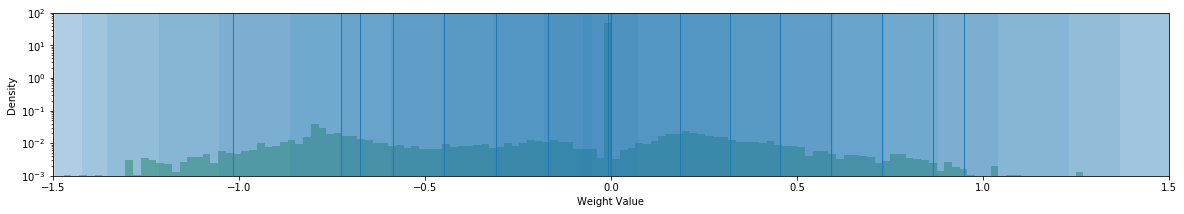

In [10]:
model, gmp, res = retrain_model(1, 0.1, 1000, 1000, 5e-6, int(0), 16, "LeNet_300_100", "sws", 'CESNT', False, "", dset='fashionmnist')
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

In [ ]:
model, gmp, res = retrain_model(250, 10, 2500, 1250, 5e-5, 5, 16, "LeNet_300_100", "kd", 'MSEST', False, "", dset='fashionmnist')
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

In [13]:
model, gmp, res = retrain_model(250, 10, 2500, 1250, 5e-6, 5, 16, "LeNet_300_100", "synth", 'MSEST', False, "", dset="fashionmnist")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 250.0 Variance: 10.0
Epoch: 10. Test Accuracy: 88.54, Prune Accuracy: 86.14, Sparsity: 34.27
Epoch: 20. Test Accuracy: 86.08, Prune Accuracy: 81.27, Sparsity: 53.63
Epoch: 30. Test Accuracy: 75.69, Prune Accuracy: 50.90, Sparsity: 98.30
Epoch: 40. Test Accuracy: 75.49, Prune Accuracy: 68.81, Sparsity: 98.24
Epoch: 50. Test Accuracy: 75.79, Prune Accuracy: 70.37, Sparsity: 98.24
Epoch: 60. Test Accuracy: 76.50, Prune Accuracy: 72.00, Sparsity: 98.24
Epoch: 70. Test Accuracy: 77.02, Prune Accuracy: 70.75, Sparsity: 98.23
Epoch: 80. Test Accuracy: 76.60, Prune Accuracy: 70.58, Sparsity: 98.23
Epoch: 90. Test Accuracy: 77.17, Prune Accuracy: 71.23, Sparsity: 98.23
Epoch: 100. Test Accuracy: 76.81, Prune Accuracy: 71.27, Sparsity: 98.23
Epoch: 110. Test Accuracy: 76.61, Prune Accuracy: 71.91, Sparsity: 98.23
Epoch: 120. Test Accuracy: 75.23, Prune Accuracy: 72.55, Sparsity: 98.23
Epoch: 130. Test Accuracy: 76.89, Prune Accur

KeyboardInterrupt: 

### 1K Datapoints

Soft-weight Sharing (SWS) & 42.7 & 99.2 & 57.8 & 97.7 \\
SWS with Knowledge Distillation  (KD) & 46.2 & 99.7 &  35.0 & 98.7 \\
SWS with KD on Synthetic Data & 84.7 & 99.5 & 73.8 & 98.3 \\

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 1.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.33, Prune Accuracy: 98.17, Sparsity: 41.09
Epoch: 20. Test Accuracy: 98.24, Prune Accuracy: 97.79, Sparsity: 54.57
Epoch: 30. Test Accuracy: 97.80, Prune Accuracy: 96.71, Sparsity: 65.59
Epoch: 40. Test Accuracy: 97.38, Prune Accuracy: 94.65, Sparsity: 74.26
Epoch: 50. Test Accuracy: 96.56, Prune Accuracy: 90.21, Sparsity: 80.56
Epoch: 60. Test Accuracy: 95.65, Prune Accuracy: 85.11, Sparsity: 84.90
Epoch: 70. Test Accuracy: 94.70, Prune Accuracy: 84.99, Sparsity: 87.22
Epoch: 80. Test Accuracy: 93.99, Prune Accuracy: 80.61, Sparsity: 89.18
Epoch: 90. Test Accuracy: 93.53, Prune Accuracy: 78.42, Sparsity: 90.37
Epoch: 100. Test Accuracy: 92.68, Prune Accuracy: 75.58, Sparsity: 91.03
Epoch: 110. Test Accuracy: 92.41, Prune Accuracy: 72.69, Sparsity: 91.68
Epoch: 120. Test Accuracy: 91.68, Prune Accuracy: 70.02, Sparsity: 92.45
Epoch: 130. Test Accuracy: 91.73, Prune Accuracy

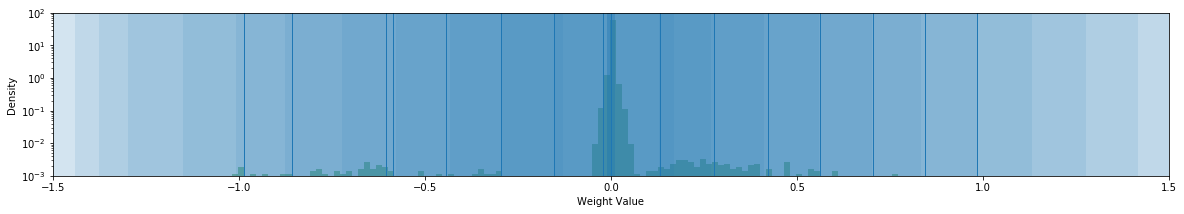

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 250.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.36, Prune Accuracy: 98.37, Sparsity: 39.12
Epoch: 20. Test Accuracy: 98.19, Prune Accuracy: 97.93, Sparsity: 50.97
Epoch: 30. Test Accuracy: 97.71, Prune Accuracy: 97.55, Sparsity: 59.16
Epoch: 40. Test Accuracy: 96.90, Prune Accuracy: 96.80, Sparsity: 64.92
Epoch: 50. Test Accuracy: 96.13, Prune Accuracy: 96.15, Sparsity: 68.82
Epoch: 60. Test Accuracy: 95.20, Prune Accuracy: 94.76, Sparsity: 71.51
Epoch: 70. Test Accuracy: 94.53, Prune Accuracy: 94.09, Sparsity: 73.26
Epoch: 80. Test Accuracy: 93.63, Prune Accuracy: 92.69, Sparsity: 74.67
Epoch: 90. Test Accuracy: 93.16, Prune Accuracy: 92.06, Sparsity: 75.48
Epoch: 100. Test Accuracy: 92.66, Prune Accuracy: 90.53, Sparsity: 77.03
Epoch: 110. Test Accuracy: 92.46, Prune Accuracy: 88.74, Sparsity: 78.12
Epoch: 120. Test Accuracy: 92.02, Prune Accuracy: 81.59, Sparsity: 79.18
Epoch: 130. Test Accuracy: 92.11, Prune Accur

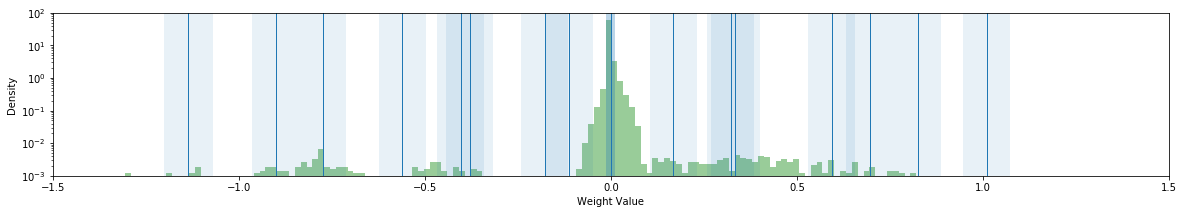

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 250.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.66, Prune Accuracy: 96.70, Sparsity: 59.55
Epoch: 20. Test Accuracy: 92.93, Prune Accuracy: 63.13, Sparsity: 97.01
Epoch: 30. Test Accuracy: 89.37, Prune Accuracy: 84.25, Sparsity: 94.18
Epoch: 40. Test Accuracy: 87.58, Prune Accuracy: 83.77, Sparsity: 99.51
Epoch: 50. Test Accuracy: 87.62, Prune Accuracy: 85.20, Sparsity: 99.51
Epoch: 60. Test Accuracy: 87.80, Prune Accuracy: 85.61, Sparsity: 99.51
Epoch: 70. Test Accuracy: 87.30, Prune Accuracy: 86.11, Sparsity: 99.52
Epoch: 80. Test Accuracy: 87.87, Prune Accuracy: 85.95, Sparsity: 99.52
Epoch: 90. Test Accuracy: 87.27, Prune Accuracy: 85.16, Sparsity: 99.52
Epoch: 100. Test Accuracy: 87.51, Prune Accuracy: 85.64, Sparsity: 99.52
Epoch: 110. Test Accuracy: 87.08, Prune Accuracy: 85.53, Sparsity: 99.52
Epoch: 120. Test Accuracy: 87.25, Prune Accuracy: 85.01, Sparsity: 99.52
Epoch: 130. Test Accuracy: 87.34, Prune Accur

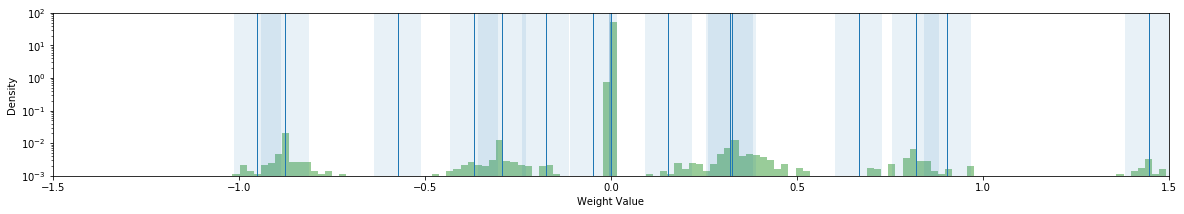

In [15]:
model, gmp, res = retrain_model(1, 0.1, 1000, 1000, 5e-6, int(0), 16, "LeNet_300_100", "sws", 'CESNT', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))
model, gmp, res = retrain_model(250, 10, 2500, 1250, 5e-6, 5, 16, "LeNet_300_100", "kd", 'MSEST', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))
model, gmp, res = retrain_model(250, 10, 2500, 1250, 5e-6, 5, 16, "LeNet_300_100", "synth", 'MSEST', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 1.0 Variance: 0.1
Epoch: 10. Test Accuracy: 89.60, Prune Accuracy: 88.51, Sparsity: 26.77
Epoch: 20. Test Accuracy: 89.61, Prune Accuracy: 88.24, Sparsity: 34.92
Epoch: 30. Test Accuracy: 89.33, Prune Accuracy: 88.32, Sparsity: 41.43
Epoch: 40. Test Accuracy: 89.18, Prune Accuracy: 87.56, Sparsity: 47.85
Epoch: 50. Test Accuracy: 88.99, Prune Accuracy: 84.43, Sparsity: 54.04
Epoch: 60. Test Accuracy: 88.60, Prune Accuracy: 79.51, Sparsity: 59.44
Epoch: 70. Test Accuracy: 87.84, Prune Accuracy: 75.03, Sparsity: 60.99
Epoch: 80. Test Accuracy: 87.47, Prune Accuracy: 70.81, Sparsity: 65.43
Epoch: 90. Test Accuracy: 87.02, Prune Accuracy: 67.10, Sparsity: 69.70
Epoch: 100. Test Accuracy: 85.48, Prune Accuracy: 58.42, Sparsity: 66.08
Epoch: 110. Test Accuracy: 85.76, Prune Accuracy: 53.25, Sparsity: 77.20
Epoch: 120. Test Accuracy: 84.42, Prune Accuracy: 36.25, Sparsity: 81.52
Epoch: 130. Test Accuracy: 82.78, Prune Accuracy

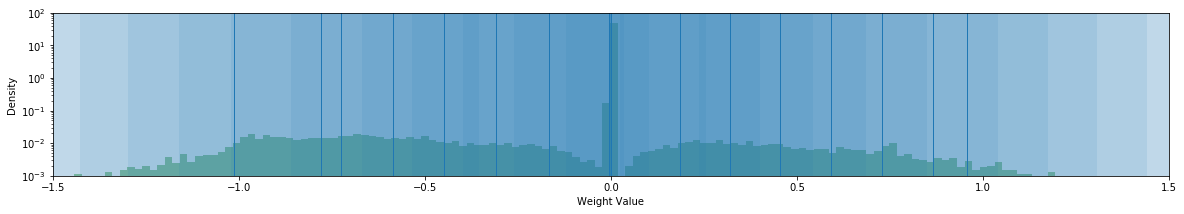

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 250.0 Variance: 10.0
Epoch: 10. Test Accuracy: 89.75, Prune Accuracy: 88.39, Sparsity: 25.36
Epoch: 20. Test Accuracy: 89.82, Prune Accuracy: 88.07, Sparsity: 31.05
Epoch: 30. Test Accuracy: 89.62, Prune Accuracy: 88.18, Sparsity: 34.28
Epoch: 40. Test Accuracy: 89.57, Prune Accuracy: 88.17, Sparsity: 37.70
Epoch: 50. Test Accuracy: 89.39, Prune Accuracy: 88.57, Sparsity: 41.82
Epoch: 60. Test Accuracy: 89.07, Prune Accuracy: 88.33, Sparsity: 45.70
Epoch: 70. Test Accuracy: 88.90, Prune Accuracy: 87.63, Sparsity: 50.53
Epoch: 80. Test Accuracy: 88.24, Prune Accuracy: 85.37, Sparsity: 55.47
Epoch: 90. Test Accuracy: 87.94, Prune Accuracy: 82.44, Sparsity: 59.03
Epoch: 100. Test Accuracy: 87.21, Prune Accuracy: 78.71, Sparsity: 64.88
Epoch: 110. Test Accuracy: 86.59, Prune Accuracy: 63.44, Sparsity: 73.77
Epoch: 120. Test Accuracy: 85.84, Prune Accuracy: 43.35, Sparsity: 84.56
Epoch: 130. Test Accuracy: 84.69, Prune Accur

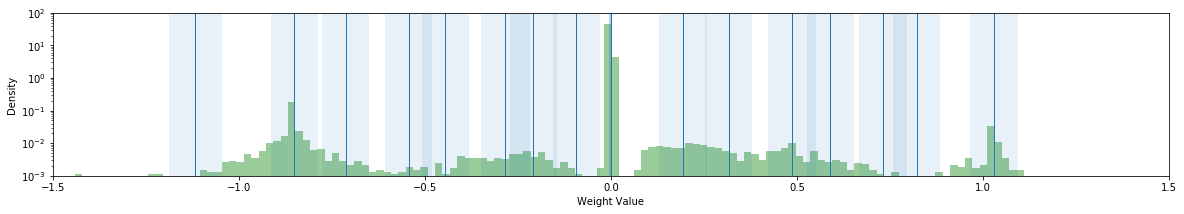

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 250.0 Variance: 10.0
Epoch: 10. Test Accuracy: 88.64, Prune Accuracy: 87.31, Sparsity: 34.84
Epoch: 20. Test Accuracy: 84.81, Prune Accuracy: 79.41, Sparsity: 55.55
Epoch: 30. Test Accuracy: 75.30, Prune Accuracy: 53.50, Sparsity: 98.27
Epoch: 40. Test Accuracy: 73.95, Prune Accuracy: 67.00, Sparsity: 98.24
Epoch: 50. Test Accuracy: 75.54, Prune Accuracy: 71.96, Sparsity: 98.25
Epoch: 60. Test Accuracy: 75.91, Prune Accuracy: 73.22, Sparsity: 98.25
Epoch: 70. Test Accuracy: 76.52, Prune Accuracy: 72.88, Sparsity: 98.25
Epoch: 80. Test Accuracy: 75.80, Prune Accuracy: 73.26, Sparsity: 98.25
Epoch: 90. Test Accuracy: 76.15, Prune Accuracy: 72.69, Sparsity: 98.25
Epoch: 100. Test Accuracy: 75.54, Prune Accuracy: 72.62, Sparsity: 98.25
Epoch: 110. Test Accuracy: 75.63, Prune Accuracy: 73.10, Sparsity: 98.25
Epoch: 120. Test Accuracy: 74.02, Prune Accuracy: 73.42, Sparsity: 98.25
Epoch: 130. Test Accuracy: 74.74, Prune Accur

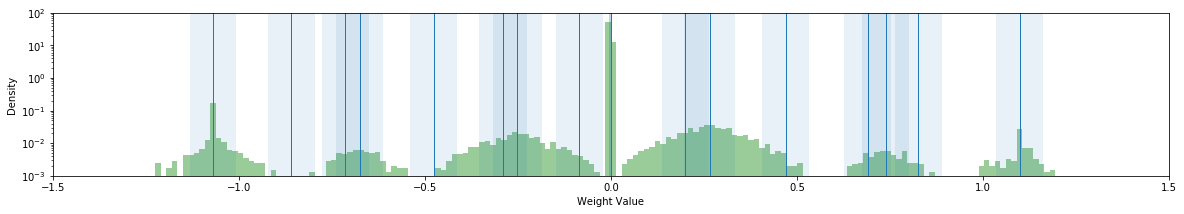

In [16]:
model, gmp, res = retrain_model(1, 0.1, 1000, 1000, 5e-6, int(0), 16, "LeNet_300_100", "sws", 'CESNT', False, "", dset="fashionmnist")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))
model, gmp, res = retrain_model(250, 10, 2500, 1250, 5e-6, 5, 16, "LeNet_300_100", "kd", 'MSEST', False, "", dset="fashionmnist")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))
model, gmp, res = retrain_model(250, 10, 2500, 1250, 5e-6, 5, 16, "LeNet_300_100", "synth", 'MSEST', False, "", dset="fashionmnist")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))